In [8]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.datasets import mnist, cifar10
from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.python.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle
import itertools


In [10]:
LABELS = { 0:'A',  1:'B',  2:'C',  3:'D',  4:'E',  5:'F',  6:'G',  7:'H',  8:'I',  9:'K', 
          10:'L', 11:'M', 12:'N', 13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U', 
          20:'V', 21:'W', 22:'X', 23:'Y'}

In [11]:
def cross_entropy(y, o):
    return - np.sum(y * np.log10(o + 1e-10))

def errors(targets, predictions, y_test_cat, probabilities, n=10):
    header = ['img_index', 'loss', 'true', 'true_prob', 'predicted', 'predicted_prob']
    errors_df = pd.DataFrame()
    for idx, (tgs, prd) in enumerate(zip(targets, predictions)):
        if tgs != prd:
            errors_df = errors_df.append(pd.Series([idx, 
                                                    cross_entropy(y_test_cat[idx], probabilities[idx]),
                                                    tgs,
                                                    probabilities[idx][tgs],
                                                    prd,
                                                    probabilities[idx][prd]]), 
                                         ignore_index=True)
    errors_df.columns = header
    result = errors_df.sort_values('loss', ascending=False)
    print("Theres were {}, misclassifications.".format(len(result)))
    return result.head(n)

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [14]:
train_df = pd.read_csv('sign_mnist_train.csv')
print(train_df.head())
test_df  = pd.read_csv('sign_mnist_test.csv')
print(test_df.head())
x_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]
print(np.unique(y_train))
x_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
print(np.unique(y_test))
for index, value in enumerate(y_train):
    if value >= 10:
        y_train[index] = value - 1
for index, value in enumerate(y_test):
    if value >= 10:
        y_test[index] = value - 1
print(np.unique(y_train))
print(np.unique(y_test))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9    ...     pixel775  pixel776  pixel777  pixel778  pixel779  \
0     153    ...          207       207       207       207       206   
1     158    ...           69       149       128        87        94   
2     187    ...          202       201       200       199       198   
3     210    ...          235       234       233       231       230   
4     185    ...           92       105       105       108       133   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0       206       206       204       203       20

In [22]:
inputs = Input(shape=(784,))
f = Dense(400, activation='relu')(inputs)
f = Dense(200, activation='relu')(f)
f = Dense(100, activation='relu')(f)
f = Dense(100, activation='relu')(f)
f = Dense( 50, activation='relu')(f)
f = Dropout(0.1)(f)
outputs = Dense(24, activation='softmax')(f)
model = Model(inputs=inputs, outputs=outputs)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_34 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_35 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_36 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train / 255, 
                    y=to_categorical(y_train.values, num_classes=24), 
                    batch_size=512, epochs=20, 
                    validation_split=0.2)

Train on 21964 samples, validate on 5491 samples
Epoch 1/20
21964/21964 [==============================] - 3s 119us/step - loss: 2.9711 - acc: 0.1074 - val_loss: 2.6328 - val_acc: 0.2364
Epoch 2/20
21964/21964 [==============================] - 1s 59us/step - loss: 2.4358 - acc: 0.2263 - val_loss: 2.0198 - val_acc: 0.3460
Epoch 3/20
21964/21964 [==============================] - 1s 57us/step - loss: 1.9585 - acc: 0.3464 - val_loss: 1.7060 - val_acc: 0.4110
Epoch 4/20
21964/21964 [==============================] - 1s 59us/step - loss: 1.6500 - acc: 0.4393 - val_loss: 1.3560 - val_acc: 0.5571
Epoch 5/20
21964/21964 [==============================] - 1s 58us/step - loss: 1.3961 - acc: 0.5245 - val_loss: 1.1513 - val_acc: 0.6336
Epoch 6/20
21964/21964 [==============================] - 1s 63us/step - loss: 1.2184 - acc: 0.5792 - val_loss: 0.9984 - val_acc: 0.6767
Epoch 7/20
21964/21964 [==============================] - 1s 58us/step - loss: 1.0805 - acc: 0.6285 - val_loss: 0.8823 - val_acc

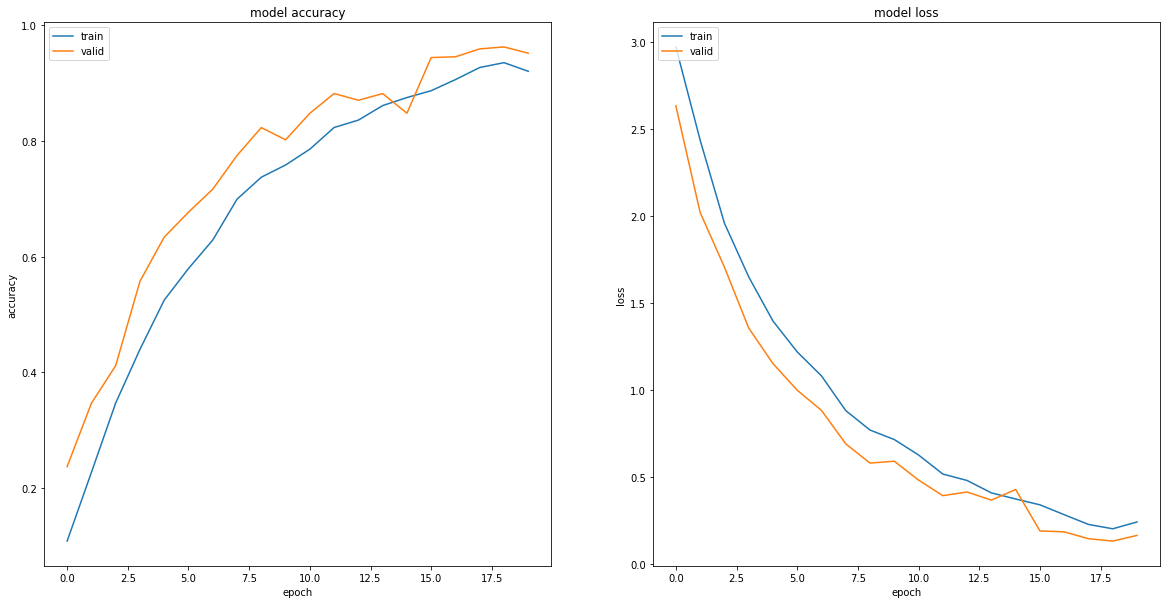

In [24]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

7172/7172 [==============================] - 0s 64us/step
Test Set	Loss : 5.143186		Accuracy :  67.83%


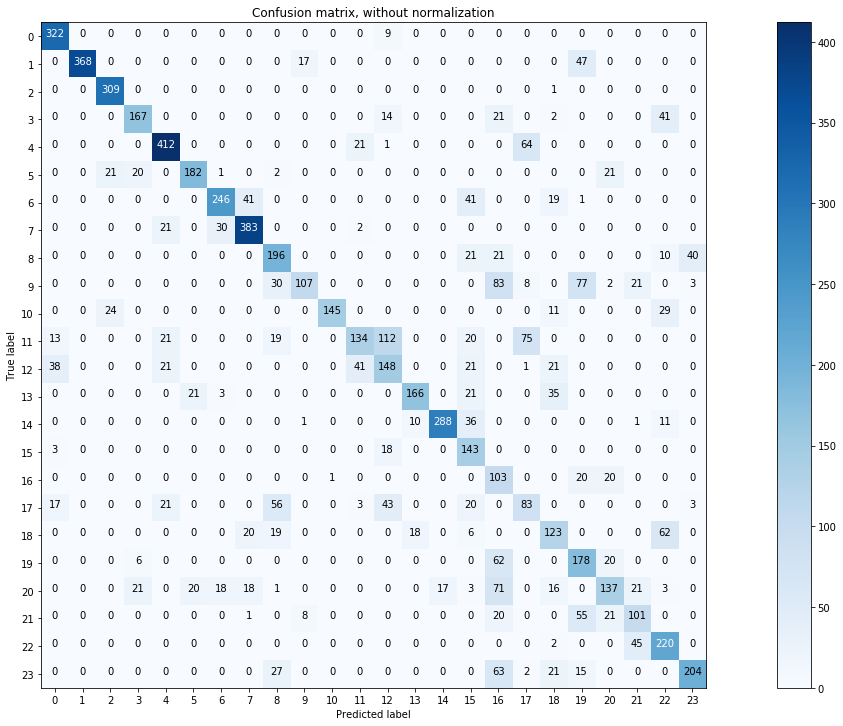

In [25]:
loss, acc = model.evaluate(x=x_test, y=to_categorical(y_test, 24))
print("Test Set\tLoss : {:2f}\t\tAccuracy : {:6.2f}%".format(loss, 100 * acc))
targets = np.argmax(to_categorical(y_test, 24), axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
# print(cm)
classes = np.unique(y_test)
plot_confusion_matrix(cm, classes=classes)

In [26]:
top_errors = errors(targets, predictions, to_categorical(y_test, 24), probabilities, n=10)
print(top_errors)

Theres were 2307, misclassifications.
      img_index  loss  true  true_prob  predicted  predicted_prob
0           1.0  10.0   5.0        0.0        3.0             1.0
1529     4684.0  10.0  23.0        0.0       16.0             1.0
1522     4657.0  10.0  23.0        0.0       16.0             1.0
1523     4661.0  10.0  17.0        0.0       12.0             1.0
1524     4667.0  10.0   7.0        0.0        6.0             1.0
1526     4672.0  10.0  18.0        0.0       22.0             1.0
1527     4675.0  10.0   9.0        0.0       19.0             1.0
1528     4679.0  10.0  19.0        0.0       16.0             1.0
1530     4685.0  10.0  20.0        0.0       16.0             1.0
1520     4650.0  10.0  23.0        0.0       16.0             1.0


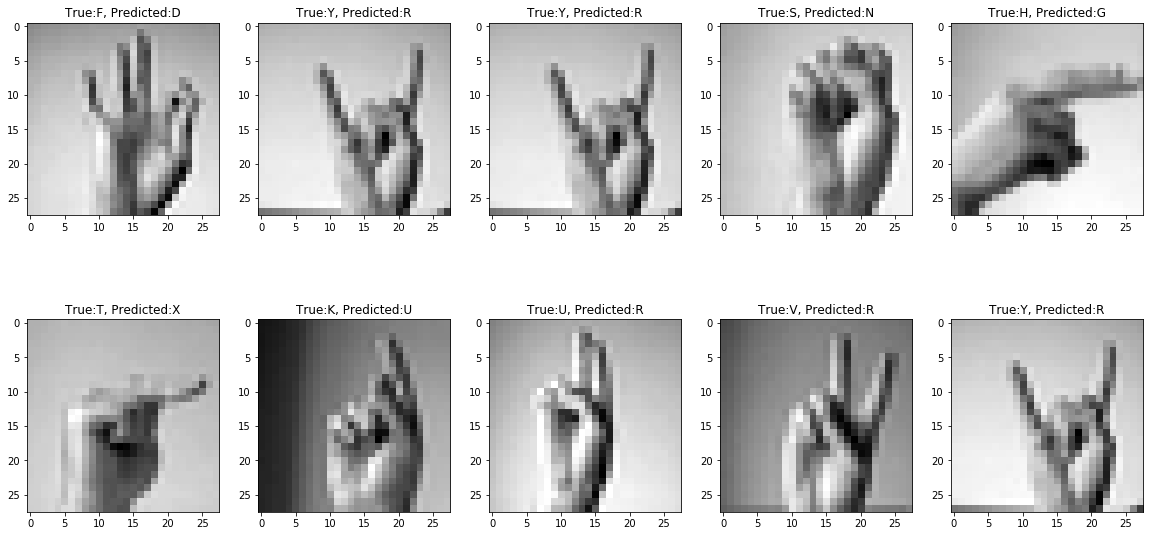

In [27]:
plt.figure(figsize=(20, 10))
for n in range(10):
    plt.subplot(2,5,n+1)
    sample = x_test.iloc[int(top_errors.img_index.iloc[n])].values.reshape(28, -1)
    plt.imshow(sample, cmap='gray')
    plt.title("True:{}, Predicted:{}".format(LABELS[int(top_errors.true.iloc[n])],
                                             LABELS[int(top_errors.predicted.iloc[n])]))
plt.show()